In [244]:
import sys
import numpy as np
from scipy.constants import c as C
import FTIR_functions as FTIR
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rcParams.update({"font.size": 28, "xtick.direction": "in", "ytick.direction": "in", "xtick.minor.visible": True, "ytick.minor.visible": True})
np.set_printoptions(threshold=sys.maxsize)

In [245]:
File = open("data\\plotDataqq.txt", 'rt')
epac_data = np.loadtxt(File, delimiter = " ")
File.close()

ideal_z, ideal_bunch = epac_data.T # Z displacement in um, bunch profile normalised to its peak, the electrons are traveling to the right such that the rightmost electrons will reach the detector first.

ideal_time = ideal_z *1e-6 /C # in s
ideal_bunch = ideal_bunch[::-1] # electrons are traveling to the right so the rightmost electrons arrive first.
ideal_sampling_period = np.median(np.diff(ideal_time)) # should be regularly spaced anyway
ideal_N = len(ideal_time)

In [246]:
padding = 2000 # number of samples to zero padd at the end of the bunch

ideal_time = np.append(ideal_time, ideal_time[-1] +ideal_sampling_period*np.arange(padding))
ideal_bunch = np.append(ideal_bunch, np.zeros(padding))
padded_N = len(ideal_bunch) # = ideal_N +padding

ideal_bunch[120:] *= 0

In [247]:
### Replace the EPAC bunch with a gaussian distrobution. Useful for testing.

#ideal_bunch = FTIR.gaussian(ideal_time, 30e-15, 10e-15) + 0.5*FTIR.gaussian(ideal_time, 60e-15, 5e-15)
ideal_bunch1 = FTIR.gaussian(ideal_time, 30e-15, 10e-15)
ideal_bunch2 = 0.8*FTIR.gaussian(ideal_time, 60e-15, 5e-15)

In [248]:
### Replace the EPAC bunch with a dirac deltas. Useful for testing.

#ideal_bunch = np.zeros_like(ideal_bunch)
#ideal_bunch[100] = 1.0
#ideal_bunch[200] = 0.2

In [249]:
### Replace the EPAC bunch with a boxcar. Useful for testing.

#ideal_bunch = np.zeros_like(ideal_bunch)
#ideal_bunch[100:120] = 1.0

In [250]:
ideal_CFF = np.fft.rfft(ideal_bunch, norm= "forward")
ideal_CFF /= np.max(ideal_CFF) #normalise to peak
ideal_freqs = np.fft.rfftfreq(padded_N, ideal_sampling_period)
ideal_FF = np.abs(ideal_CFF)**2
ideal_FF /= np.max(ideal_FF) #normalise to peak

ideal_CFF1 = np.fft.rfft(ideal_bunch1, norm= "ortho")
ideal_FF1 = np.abs(ideal_CFF1)**2

ideal_CFF2 = np.fft.rfft(ideal_bunch2, norm= "ortho")
ideal_FF2 = np.abs(ideal_CFF2)**2

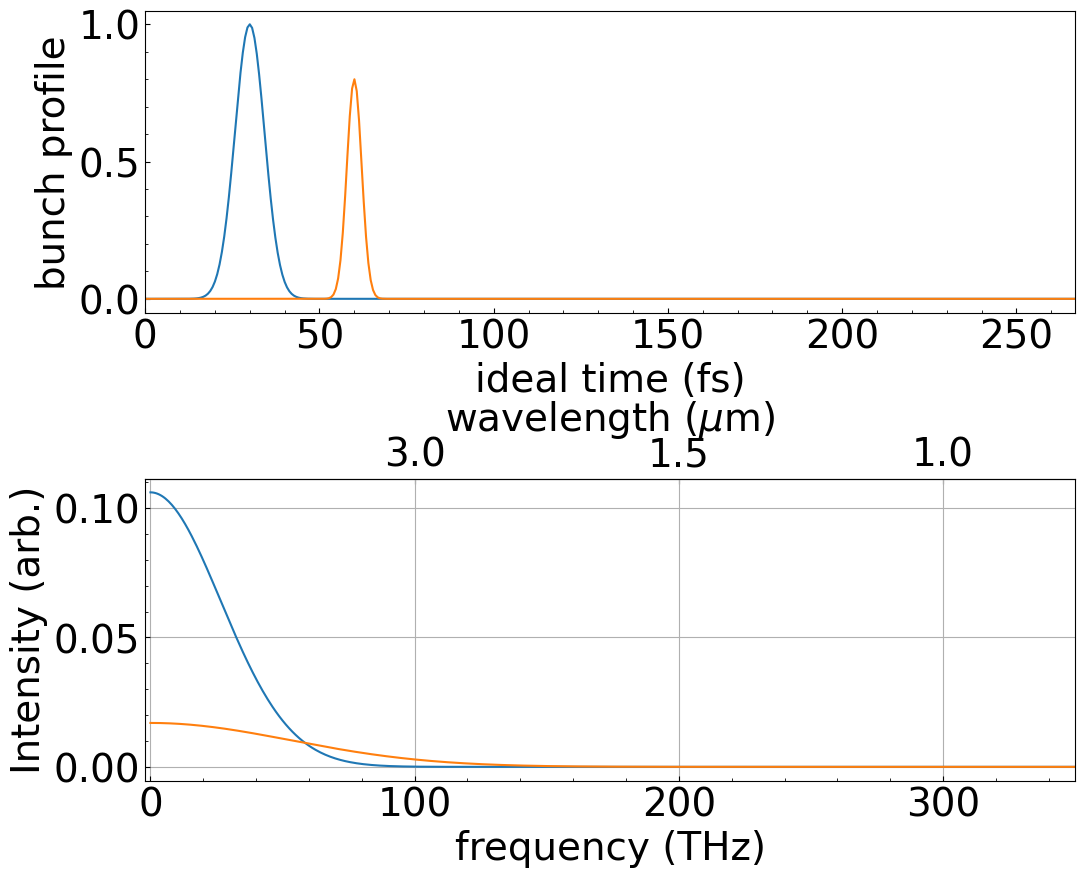

In [251]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.55})

axs[0].plot(ideal_time *1e15, ideal_bunch1)
axs[0].plot(ideal_time *1e15, ideal_bunch2)
axs[0].set(xlabel= "ideal time (fs)", ylabel= "bunch profile", xlim= (0, ideal_N*ideal_sampling_period*1e15))

axs[1].plot(ideal_freqs *1e-12, ideal_FF1)
axs[1].plot(ideal_freqs *1e-12, ideal_FF2)
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 350))
axs[1].grid(True)

secax = axs[1].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax.minorticks_off() # Minor ticks will detonate your computer
secax.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

plt.show()

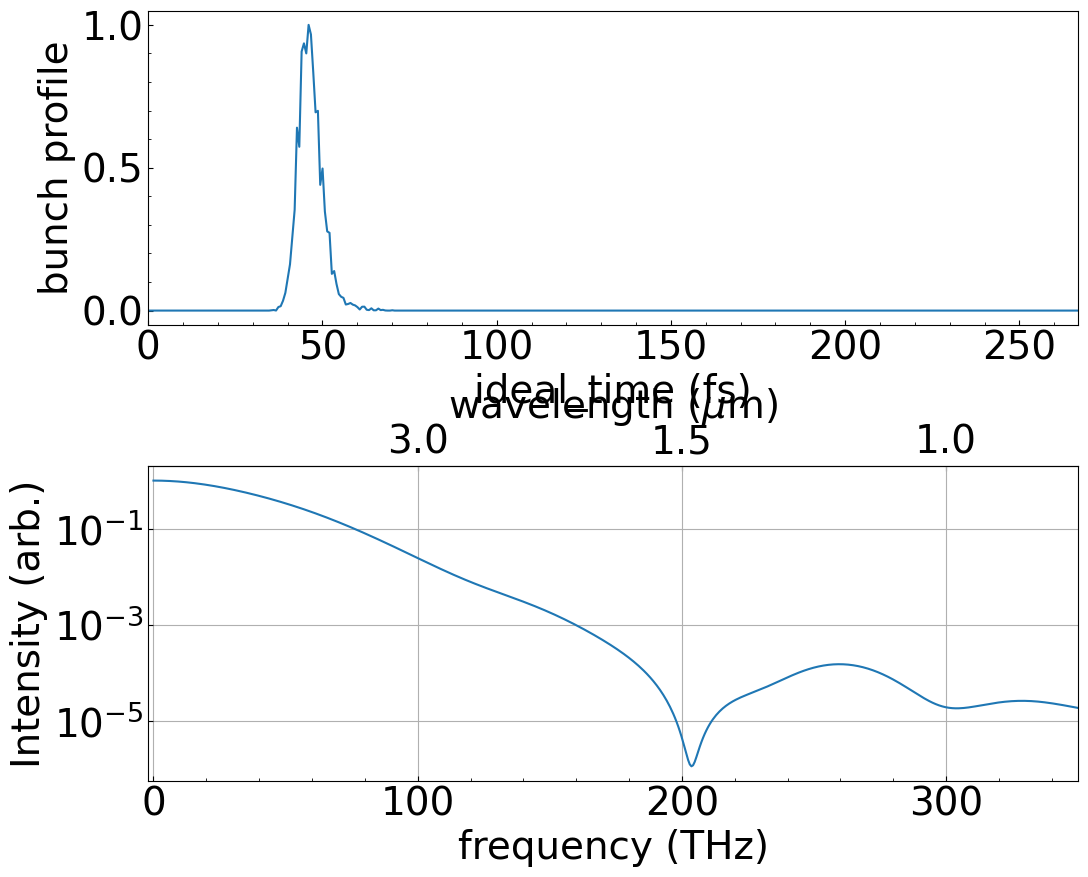

In [252]:
fig, axs = plt.subplots(2, 1, figsize= (12, 10), gridspec_kw= {"hspace": 0.45})

axs[0].plot(ideal_time *1e15, ideal_bunch)
axs[0].set(xlabel= "ideal_time (fs)", ylabel= "bunch profile", xlim= (0, ideal_N*ideal_sampling_period*1e15))

axs[1].plot(ideal_freqs *1e-12, ideal_FF)
axs[1].set(xlabel= "frequency (THz)", ylabel= "Intensity (arb.)", xlim= (-2, 350), yscale= "log")
axs[1].grid(True)

secax = axs[1].secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax.minorticks_off() # Minor ticks will detonate your computer
secax.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs[1].get_xticks()[2:]))
secax.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

plt.show()

In [253]:
kk_phase = FTIR.kramers_kronig(ideal_freqs, np.sqrt(ideal_FF))
kk_phase = -kk_phase
kk_CFF = np.sqrt(ideal_FF) *np.exp(1j*kk_phase)
gs_CFF = FTIR.gerchberg_saxon(np.sqrt(ideal_FF), tolerance= 0.8, beta= 0.8, initial_guess= 2*np.pi*np.random.rand(len(ideal_bunch)))
#gs_CFF = np.conjugate(gs_CFF)
none_CFF = np.abs(ideal_CFF)

c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\FTIR_functions.py:634: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


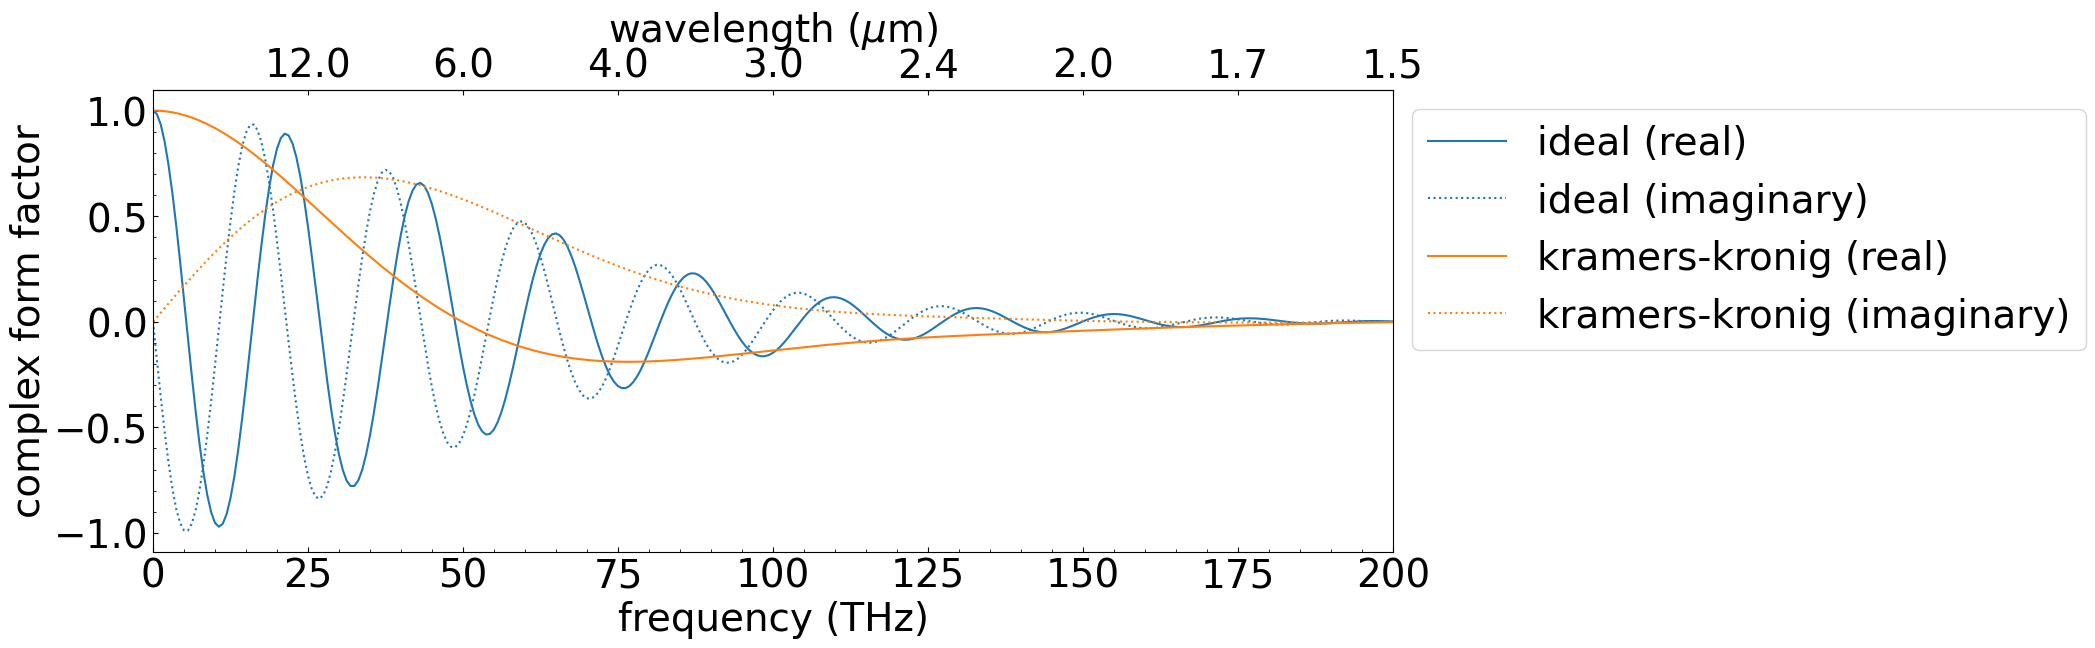

In [254]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_CFF.real, color= "tab:blue", label= "ideal (real)")
axs.plot(ideal_freqs *1e-12, ideal_CFF.imag, color= "tab:blue", linestyle= ":", label= "ideal (imaginary)")

axs.plot(ideal_freqs *1e-12, kk_CFF.real, color= "tab:orange", label= "kramers-kronig (real)")
axs.plot(ideal_freqs *1e-12, kk_CFF.imag, color= "tab:orange", linestyle= ":", label= "kramers-kronig (imaginary)")

#axs.plot(ideal_freqs *1e-12, gs_CFF.real, color= "tab:red", label= "gerchberg-saxon (real)")
#axs.plot(ideal_freqs *1e-12, gs_CFF.imag, color= "tab:red", linestyle= ":", label= "gerchberg-saxon (imaginary)")

#axs.plot(ideal_freqs *1e-12, none_CFF.real, color= "black", label= "none (real)")
#axs.plot(ideal_freqs *1e-12, none_CFF.imag, color= "black", linestyle= ":", label= "none (imaginary)")

axs.set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 200))

secax2 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax2.minorticks_off() # Minor ticks will detonate your computer
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [255]:
ideal_phase = np.unwrap(np.angle(ideal_CFF))
gs_phase = np.unwrap(np.angle(gs_CFF))
none_phase = np.unwrap(np.angle(none_CFF))

In [256]:
idx = np.nonzero(np.abs(ideal_CFF) < 1e-12)
print(*zip(ideal_CFF[idx], np.angle(ideal_CFF[idx])), sep= "\n")

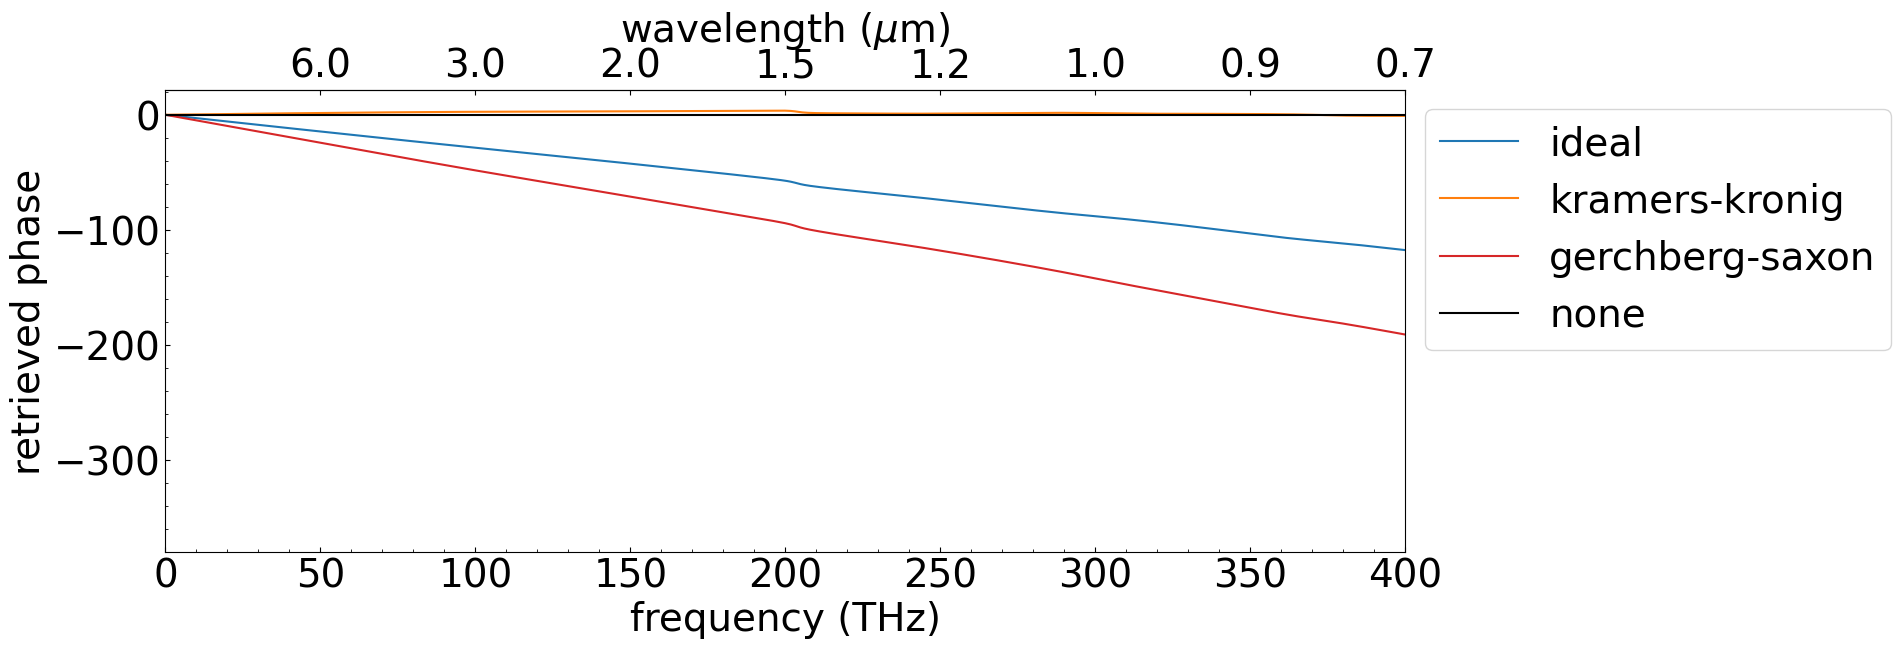

In [257]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_phase, color= "tab:blue", label= "ideal")
axs.plot(ideal_freqs *1e-12, kk_phase, color= "tab:orange", label= "kramers-kronig")
axs.plot(ideal_freqs *1e-12, gs_phase, color= "tab:red", label= "gerchberg-saxon")
axs.plot(ideal_freqs *1e-12, none_phase, color= "black", label= "none")

axs.set(xlabel= "frequency (THz)", ylabel= "retrieved phase", xlim= (1e-10, 400))

secax1 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax1.minorticks_off() # Minor ticks will detonate your computer
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [258]:
kk_bunch = np.fft.irfft(kk_CFF, norm= "forward", n= padded_N)
kk_bunch /= kk_bunch.max()
gs_bunch = np.fft.irfft(gs_CFF, norm= "forward", n= padded_N)
gs_bunch /= gs_bunch.max()
none_bunch = np.fft.irfft(none_CFF, norm= "forward", n= padded_N)
none_bunch /= none_bunch.max()

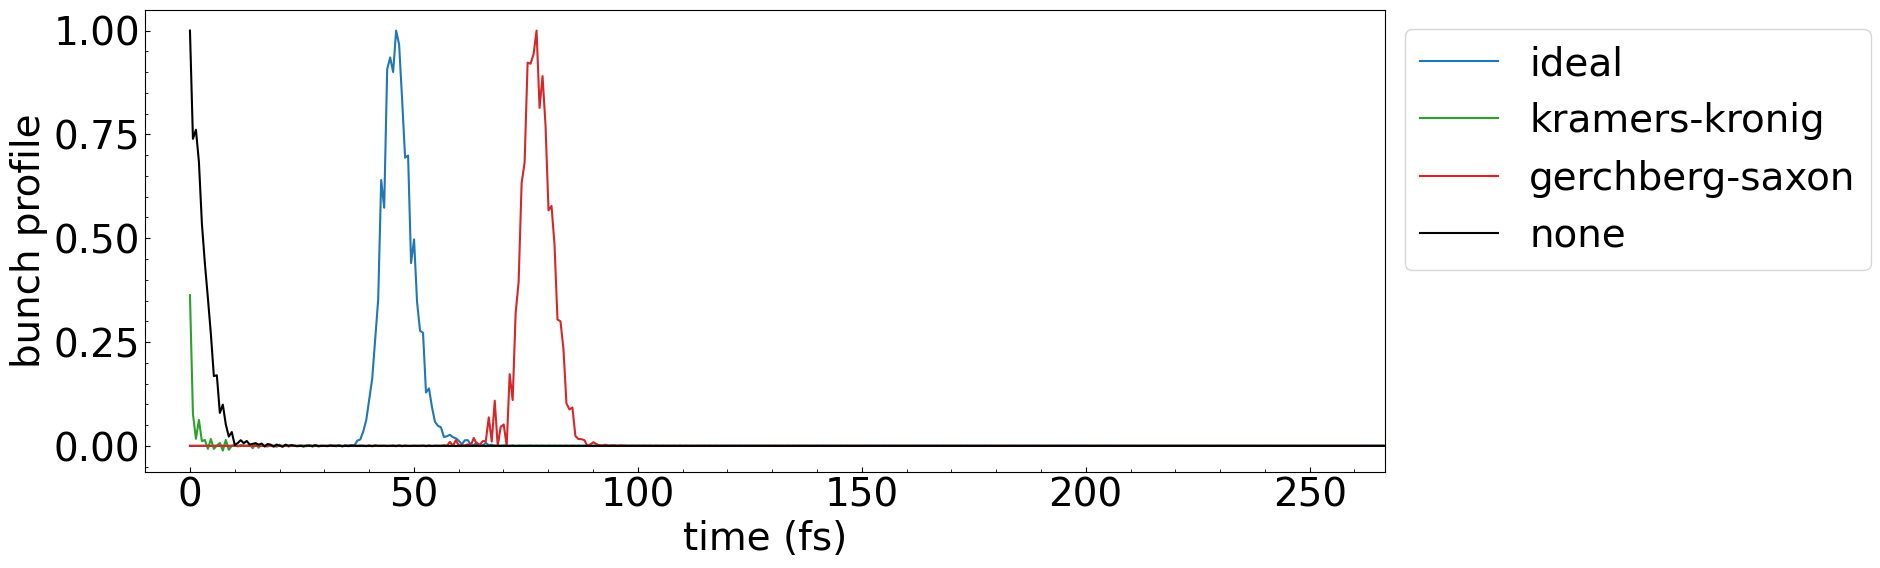

In [259]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_time *1e15, ideal_bunch, color= "tab:blue", label= "ideal")
axs.plot(ideal_time *1e15, kk_bunch, color= "tab:green", label= "kramers-kronig")
axs.plot(ideal_time *1e15, gs_bunch, color= "tab:red", label= "gerchberg-saxon")
axs.plot(ideal_time *1e15, none_bunch, color= "black", label= "none")

axs.set(xlabel= "time (fs)", ylabel= "bunch profile", xlim= (-10, ideal_N*ideal_sampling_period*1e15))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))

plt.show()

In [310]:
ideal_peak = ideal_time[np.argmax(ideal_bunch)]
kk_peak = ideal_time[np.argmax(kk_bunch)]
gs_peak = ideal_time[np.argmax(gs_bunch)]
none_peak = ideal_time[np.argmax(none_bunch)]

ideal_unfudged = ideal_phase -2*np.pi*ideal_freqs* (-10e-15) # Equivalently, change the phase
none_unfudged = none_phase -2*np.pi*ideal_freqs* (25e-15) # Equivalently, change the phase
kk_unfudged = kk_phase -2*np.pi*ideal_freqs* (50e-15) # Equivalently, change the phase
gs_unfudged = gs_phase -2*np.pi*ideal_freqs* (-20e-15) # Equivalently, change the phase

c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\THz-interferometry\FTIR_functions.py:25: RuntimeWarning: divide by zero encountered in divide
  return C*1e-6 / x #converts um to THz or vice versa. #1e4 / x # converts um to cm^-1 or vice versa.


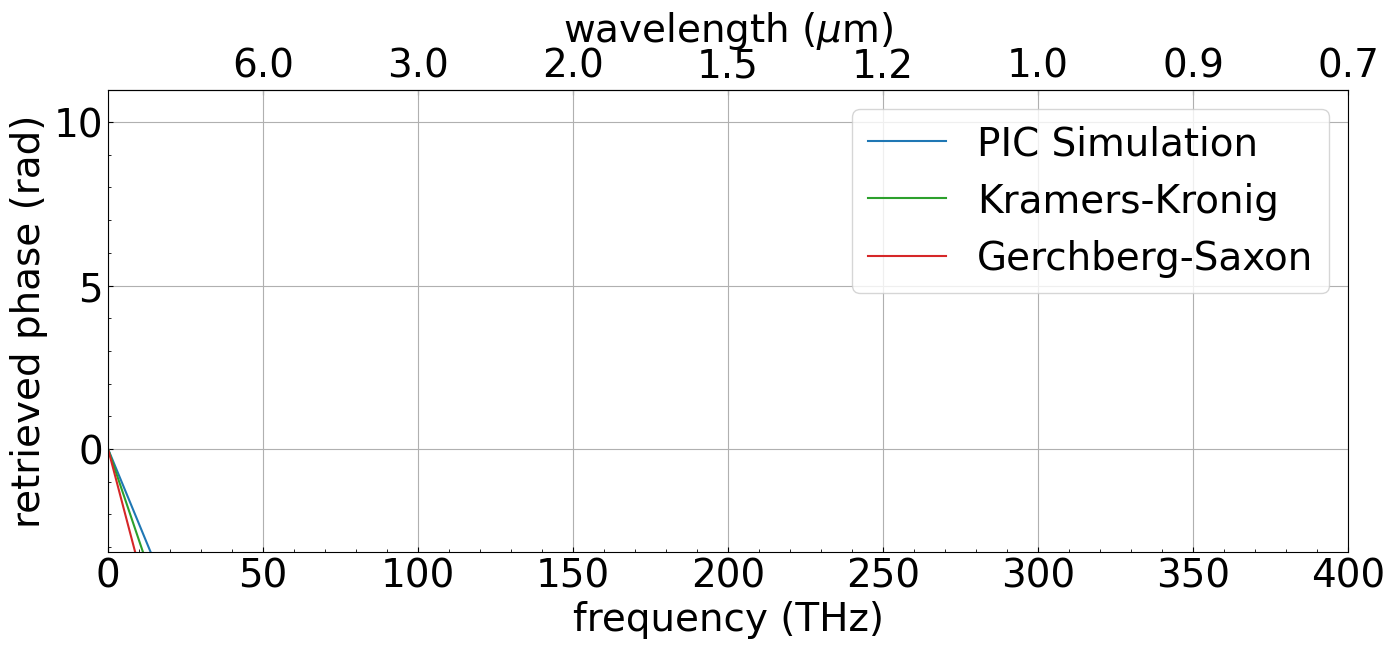

In [311]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_freqs *1e-12, ideal_unfudged, linestyle= "-", color= "tab:blue", label= "PIC Simulation")
#axs.plot(ideal_freqs *1e-12, none_unfudged, linestyle= ":", color= "black", label= "No phase retrival")
axs.plot(ideal_freqs *1e-12, kk_unfudged, linestyle= "-", color= "tab:green", label= "Kramers-Kronig")
axs.plot(ideal_freqs *1e-12, gs_unfudged, linestyle= "-", color= "tab:red", label= "Gerchberg-Saxon")

axs.set(xlabel= "frequency (THz)", ylabel= "retrieved phase (rad)", xlim= (1e-10, 400), ylim= (-np.pi, 3.5*np.pi)) #, yticks= [-np.pi, 0, np.pi, 2*np.pi, 3*np.pi])
#axs.hlines(np.pi, 0, 1, "k", transform= axs.get_yaxis_transform())

secax1 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax1.minorticks_off() # Minor ticks will detonate your computer
secax1.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax1.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper right")
axs.grid()

plt.show()

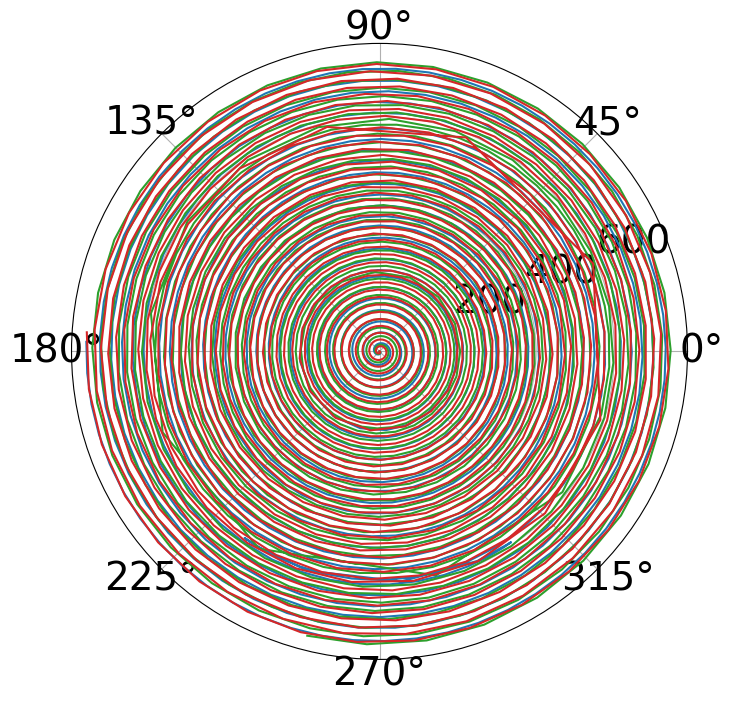

In [312]:
fig, axs = plt.subplots(figsize= (12, 8), subplot_kw={'projection': 'polar'})

axs.plot(ideal_unfudged, ideal_freqs *1e-12, color= "tab:blue", label= "PIC Simulation")
axs.plot(kk_unfudged, ideal_freqs *1e-12, color= "tab:green", label= "Kramers-Kronig")
axs.plot(gs_unfudged, ideal_freqs *1e-12, color= "tab:red", label= "Gerchberg-Saxon")

plt.show()

In [313]:
ideal_bunch = np.fft.irfft(np.abs(ideal_CFF) *np.exp(1j*ideal_unfudged), norm= "forward", n= padded_N)
ideal_bunch /= ideal_bunch.max()
kk_bunch = np.fft.irfft(np.abs(kk_CFF) *np.exp(1j*kk_unfudged), norm= "forward", n= padded_N)
kk_bunch /= kk_bunch.max()
gs_bunch = np.fft.irfft(np.abs(gs_CFF) *np.exp(1j*gs_unfudged), norm= "forward", n= padded_N)
gs_bunch /= gs_bunch.max()
none_bunch = np.fft.irfft(np.abs(none_CFF) *np.exp(1j*none_unfudged), norm= "forward", n= padded_N)
none_bunch /= none_bunch.max()

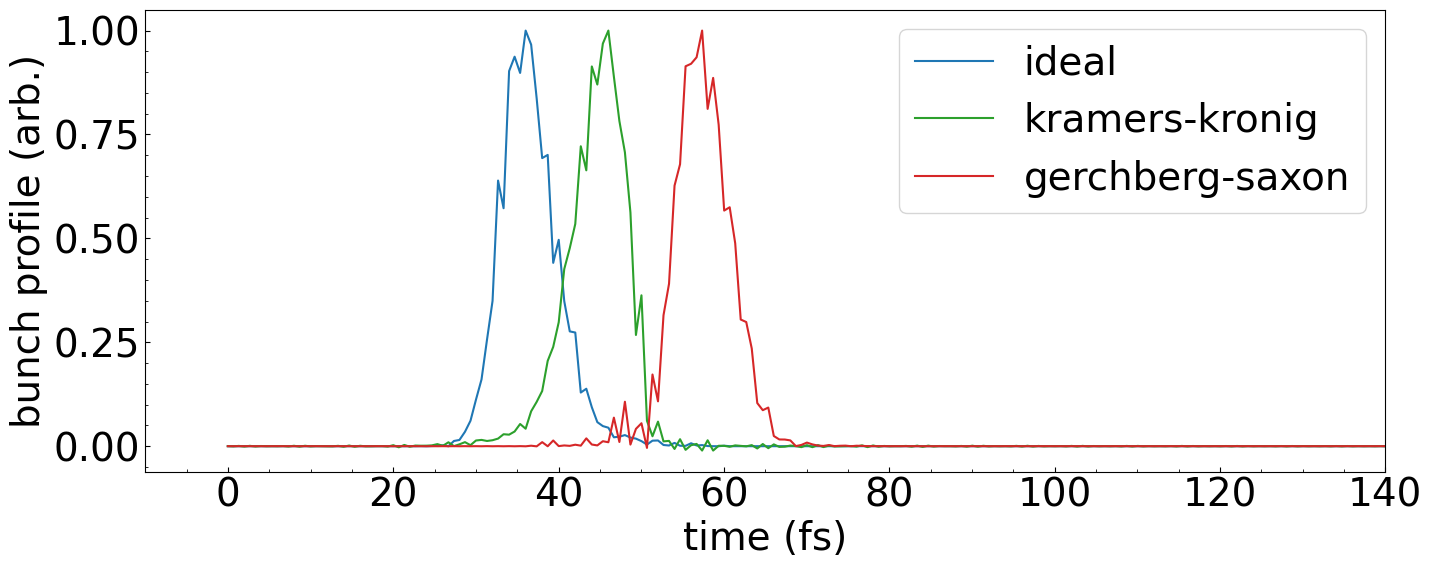

In [315]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

axs.plot(ideal_time *1e15, ideal_bunch, linestyle= "-", color= "tab:blue", label= "ideal")
#axs.plot(ideal_time *1e15, none_bunch, linestyle= "-", color= "black", label= "none")
axs.plot(ideal_time *1e15, kk_bunch, linestyle= "-", color= "tab:green", label= "kramers-kronig")
axs.plot(ideal_time *1e15, gs_bunch, linestyle= "-", color= "tab:red", label= "gerchberg-saxon")

axs.set(xlabel= "time (fs)", ylabel= "bunch profile (arb.)", xlim= (-10, 140)) #ideal_N*ideal_sampling_period*1e15))

axs.legend()

plt.show()

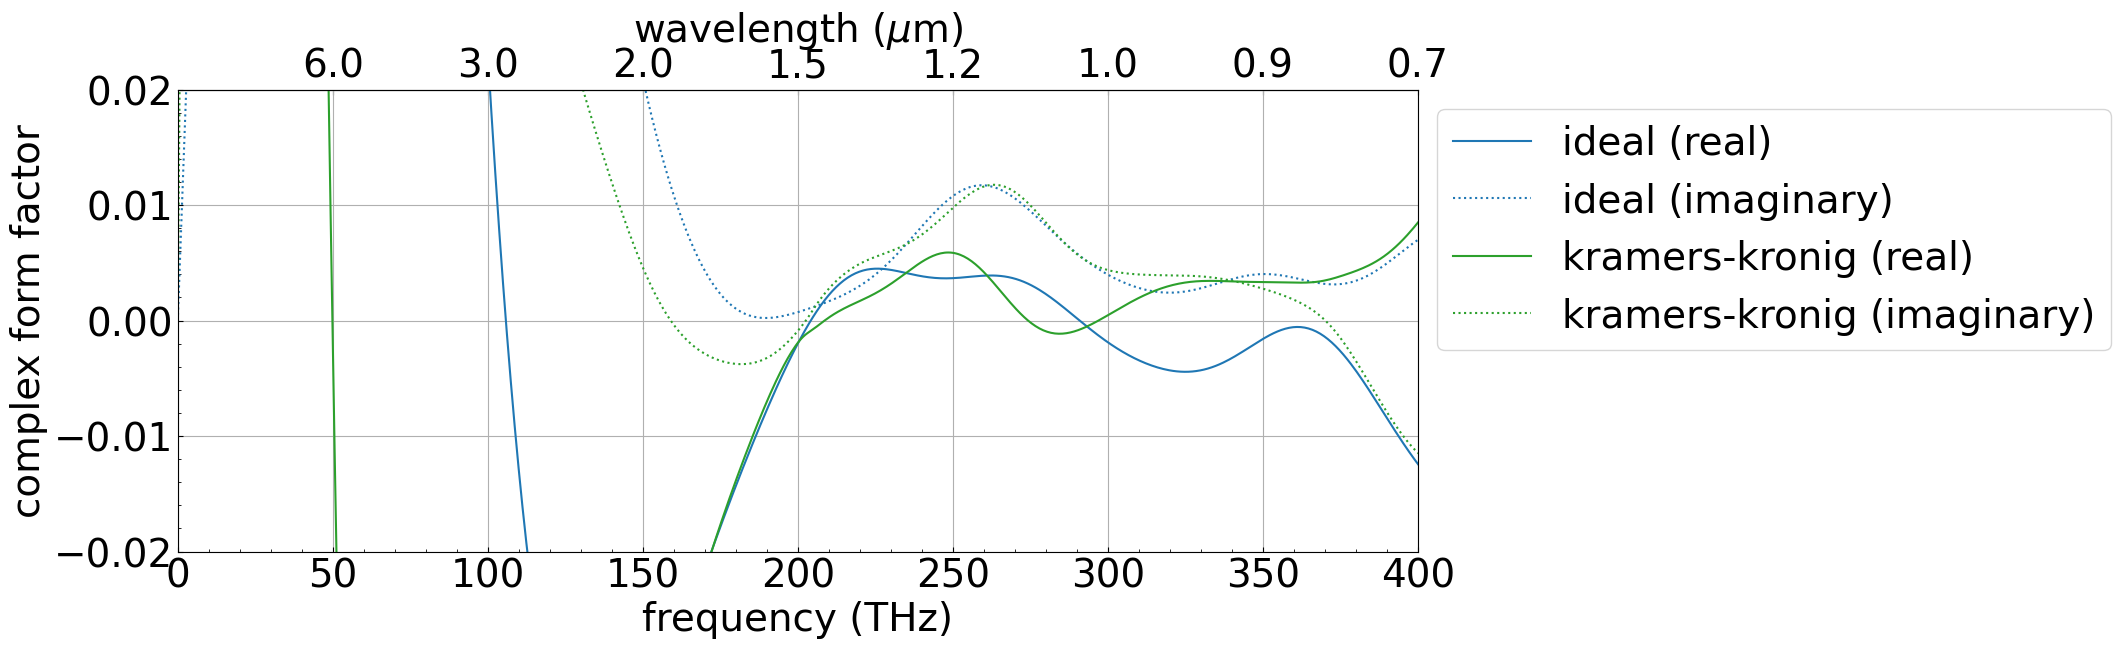

In [265]:
fig, axs = plt.subplots(1, 1, figsize= (16, 6), gridspec_kw= {"hspace": 0.6})

recentered_CFF = np.abs(ideal_CFF)*np.exp(1j*ideal_unfudged)
axs.plot(ideal_freqs *1e-12, recentered_CFF.real, color= "tab:blue", label= "ideal (real)")
axs.plot(ideal_freqs *1e-12, recentered_CFF.imag, color= "tab:blue", linestyle= ":", label= "ideal (imaginary)")

recentered_kk = np.abs(kk_CFF)*np.exp(1j*kk_unfudged)
axs.plot(ideal_freqs *1e-12, recentered_kk.real, color= "tab:green", label= "kramers-kronig (real)")
axs.plot(ideal_freqs *1e-12, recentered_kk.imag, color= "tab:green", linestyle= ":", label= "kramers-kronig (imaginary)")

recentered_gs = np.abs(gs_CFF)*np.exp(1j*gs_unfudged)
#axs.plot(ideal_freqs *1e-12, recentered_gs.real, color= "tab:red", label= "gerchberg-saxon (real)")
#axs.plot(ideal_freqs *1e-12, recentered_gs.imag, color= "tab:red", linestyle= ":", label= "gerchberg-saxon (imaginary)")

recentered_none = np.abs(none_CFF)*np.exp(1j*none_unfudged)
#axs.plot(ideal_freqs *1e-12, recentered_none.real, color= "black", label= "none (real)")
#axs.plot(ideal_freqs *1e-12, recentered_none.imag, color= "black", linestyle= ":", label= "none (imaginary)")

axs.set(xlabel= "frequency (THz)", ylabel= "complex form factor", xlim= (1e-10, 400), ylim= (-0.02, 0.02))
#axs.set_yscale("symlog", linthresh= 1e-0)

secax2 = axs.secondary_xaxis('top', functions=(FTIR.recip, FTIR.recip))
secax2.minorticks_off() # Minor ticks will detonate your computer
secax2.set(xlabel= "wavelength ($\mu$m)", xticks= FTIR.recip(axs.get_xticks()[1:]))
secax2.xaxis.set_major_formatter(FuncFormatter(FTIR.format_ticks))

axs.legend(loc= "upper left", bbox_to_anchor= (1, 1))
axs.grid()

plt.show()

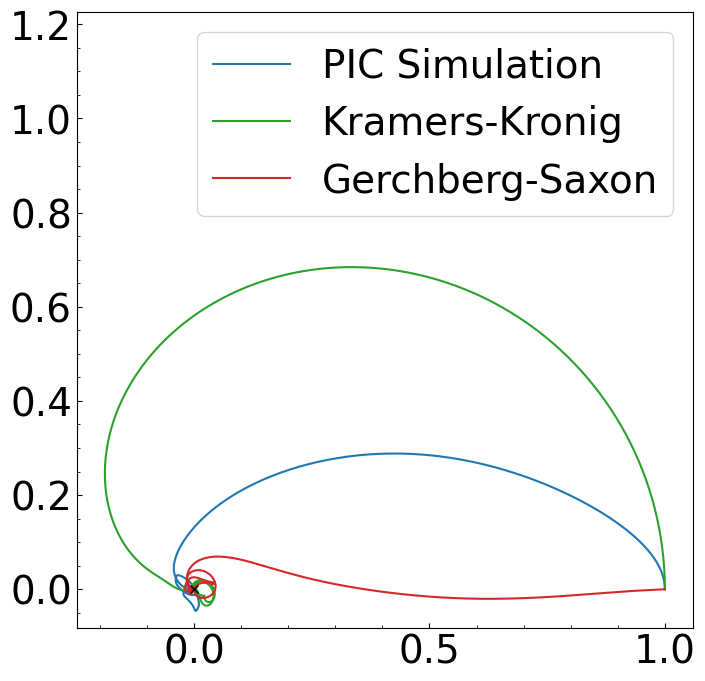

In [266]:
fig, axs = plt.subplots(figsize= (10, 8))

axs.plot(recentered_CFF.real, recentered_CFF.imag, color= "tab:blue", label= "PIC Simulation")
axs.plot(recentered_kk.real, recentered_kk.imag, color= "tab:green", label= "Kramers-Kronig")
axs.plot(recentered_gs.real, recentered_gs.imag, color= "tab:red", label= "Gerchberg-Saxon")
axs.plot(0, 0, marker= "x", color= "k")
axs.axis('square')

plt.legend()
plt.show()

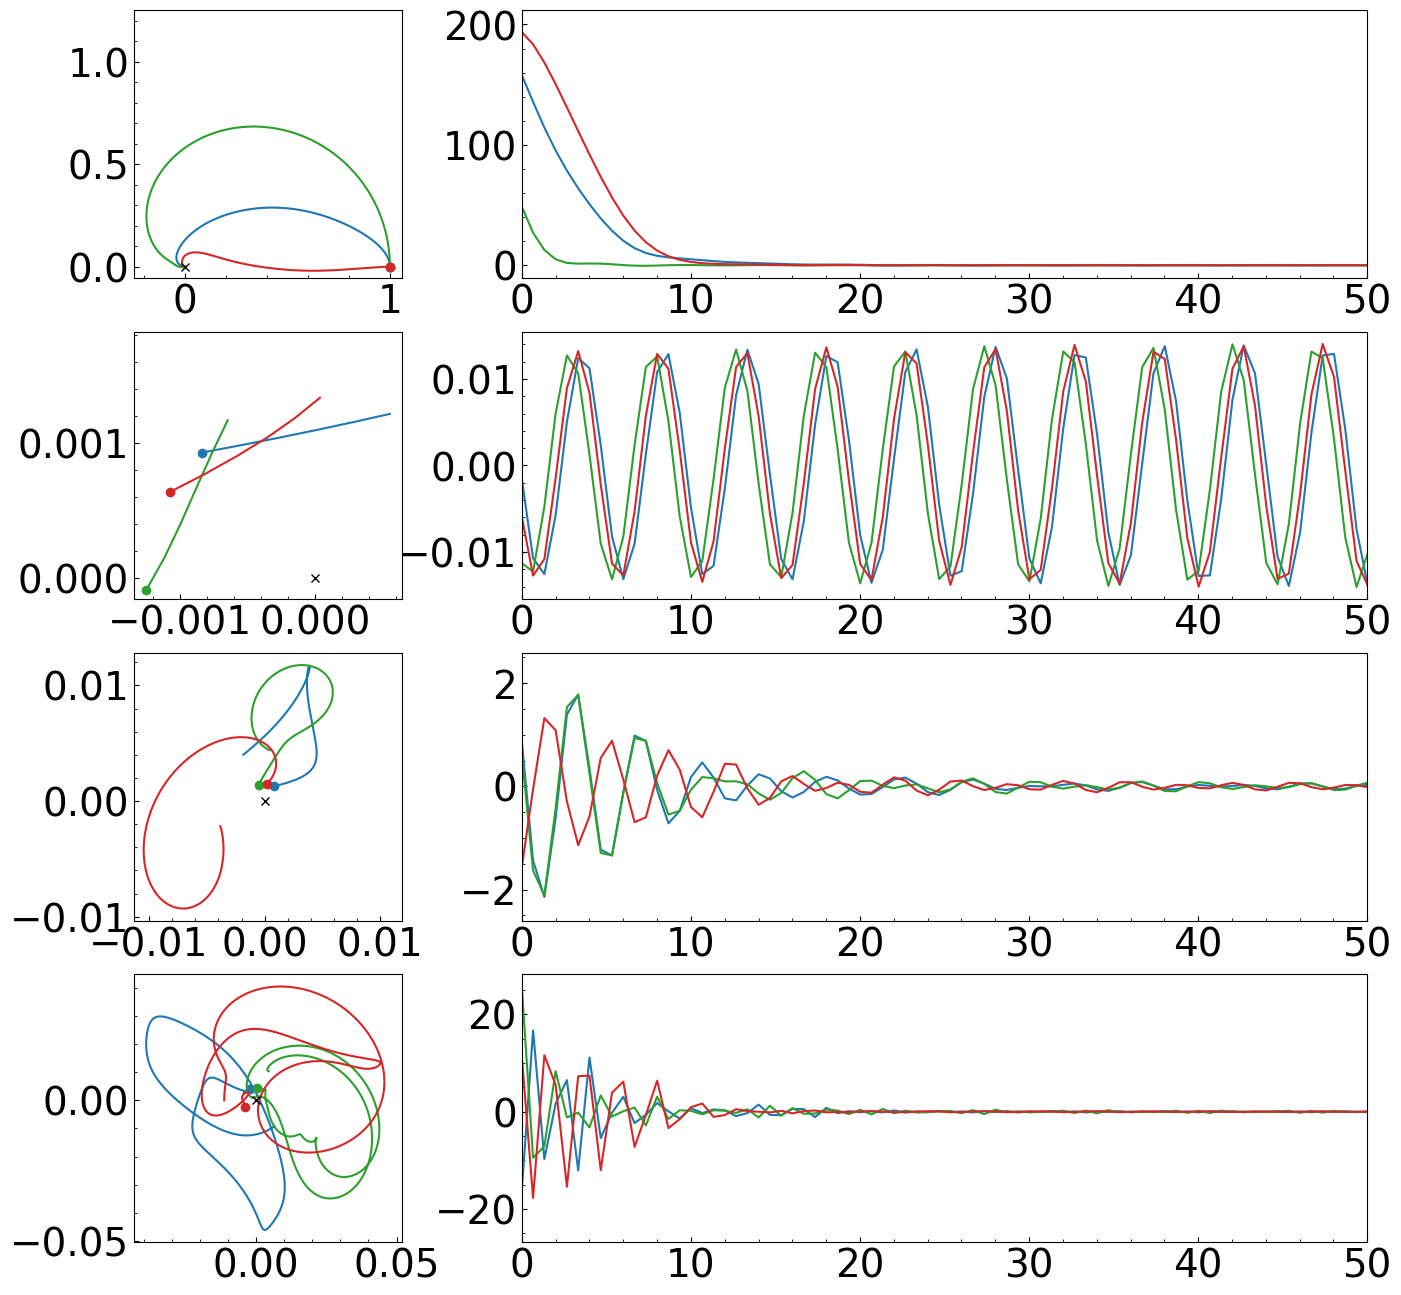

In [267]:
f1, f2, f3 = 202e12, 206e12, 300e12

band1 = ideal_freqs < f1
band2 = np.logical_and(f1 < ideal_freqs, ideal_freqs < f2)
band3 = np.logical_and(f2 < ideal_freqs, ideal_freqs < f3)
band4 = f3 < ideal_freqs
bands = [band1, band2, band3, band4]


fig, axs = plt.subplots(4, 2, figsize= (16, 16), width_ratios=(1, 3))

for ax, band in zip(axs[:,0], bands):

    ax.plot(recentered_CFF[band].real, recentered_CFF[band].imag, color= "tab:blue", markevery= [0], marker= "o", label= "PIC Simulation")
    ax.plot(recentered_kk[band].real, recentered_kk[band].imag, color= "tab:green", markevery= [0], marker= "o", label= "Kramers-Kronig")
    ax.plot(recentered_gs[band].real, recentered_gs[band].imag, color= "tab:red", markevery= [0], marker= "o", label= "Gerchberg-Saxon")
    ax.plot(0, 0, marker= "x", color= "k")
    ax.axis('square')
    #ax.legend()

for ax, band in zip(axs[:,1], bands):

    ax.plot(ideal_time *1e15, np.fft.irfft(recentered_CFF*band, norm= "forward", n= padded_N), color= "tab:blue", label= "PIC Simulation")
    ax.plot(ideal_time *1e15, np.fft.irfft(recentered_kk*band, norm= "forward", n= padded_N), color= "tab:green", label= "Kramers-Kronig")
    ax.plot(ideal_time *1e15, np.fft.irfft(recentered_gs*band, norm= "forward", n= padded_N), color= "tab:red", label= "Gerchberg-Saxon")
    ax.set(xlim= (0, 50))

plt.show()